In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import Image

## Reproducing Results:

Besides this github repository, you also need the GymGo repository as described in the readme. To generate results for the NS-ERL, use the  go_NS branch. To generate results for the ERL algorithm, use the go_noHER branch. Other branches contain integration of other concepts unrelated to this project.

## Evolutionary Reinforcement Learning (ERL):

This algorithm functions mostly as a standard genetic algorithm. There is a population of NN's that interact with the environment. Every generation, the top x% are protected from mutation/crossover, then the remaining population experiences crossover and mutation. Every transition is saved into a replay buffer in the form of (state, action, next state, reward).

The ERL algorithm also contains an external agent represented by the Deep Deterministic Policy Gradient(DDPG) algorithm. It is trained and optimized by a mini batch of transitions randomly sampled from the replay buffer.

## Novelty Search (NS):

As was discussed in my research paper, NS requires two domain specific things: 

1. A behavior characteristic (BC) 
2. Distance measure between BC's in the datastore

At the end of every game, there is a probability (p) that the agent's BC will be added to the datastore. Here we set p=0.02. The datastore is capped at a size of 10,000 BC's. In this problem space, we use the current state as the BC and the distance function between the BC's is the Euclidean Distance function. 

The NS implementation works by modifying the fitness function used within the genetic algorithm. In the standard ERL algorithm, the fitness function is the sum of rewards the agent received across all moves made during the game. In NS-ERL, we use an adaptive fitness function that works in three groups:

1. While the number of frames is less than some number (a), the fitness is entirely decided by the novelty of the agent.
2. While the number of frames is greater than a and less than b, the fitness is made up by some combination of novelty and total reward. The weight of fitness being computed by novelty is inversely proportional to the number of frames and the weight of fitness being computed by total reward is directly proportional to the number of frames.

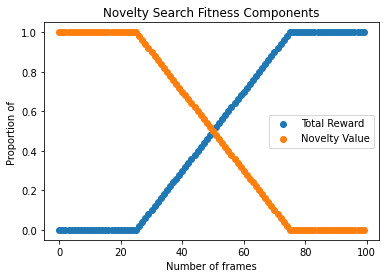

In [2]:
min_expl = 0.25
max_expl = 0.75

explore_range = (100*min_expl, 100*max_expl)
fit_values = []
nov_values = []
frames = []

for i in range(100):
    frames.append(i)

    if i < explore_range[0]:
        fit_values.append(0)
        nov_values.append(1)
    elif  explore_range[0] <= i < explore_range[1]:
        relative_gen = explore_range[1] - explore_range[0]
        gen = i - (100*min_expl)

        #fitness = (gen/relative_gen) * fit + (1-(gen/relative_gen)) * novelty
        #print(i, "mix")
        #print(gen, relative_gen)

        fit_values.append(gen/relative_gen)
        nov_values.append(1-(gen/relative_gen))
    else:
        fit_values.append(1)
        nov_values.append(0)

plt.scatter(frames, fit_values, label='Total Reward')
plt.scatter(frames, nov_values, label='Novelty Value')
plt.title("Novelty Search Fitness Components")
plt.xlabel("Number of frames")
plt.ylabel("Proportion of ")
plt.legend()
plt.show()

## Results

Experimental results were computed by comparing the ERL algorithm with the NS-ERL algorithm.

Both algorithms are executed in the Go environment against the opponent provided by the implementation of the game Go. We are using a reduced size of the board to be a 5x5 to simplify learning instead of the full 19x19 board. It is also important to note that since there is no handling for invalid actions currently, we handle this by filtering out invalid moves to only allow the agent to play valid moves.

The environment provides two reward systems:

1. Real: returns reward of 1 if the game is won, -1 if the game is lost, and 0 if the game has not finished yet.
2. Heuristic: returns the current score as the reward at every step of the game.

The real reward system is obviously much harder than the heuristic reward function due to the sparse rewards.

#### implementation details

- board size: 5x5
- Population size: 10
- Replay buffer size: 1000000
- Number of frames: 25000
- Synchronization period: 10
- NS Datastore size limit: 10000
- k nearest neighbors for NS: 25
- Probability of adding BC to NS datastore: 0.02

We look at two metrics to observe results:

1. Average reward received each generation over the number of games played
2. Number of games won over the number of games played

All results images have been generated in the file called "analysis.ipynb". Refer there to review code.

### Heuristic Rewards:

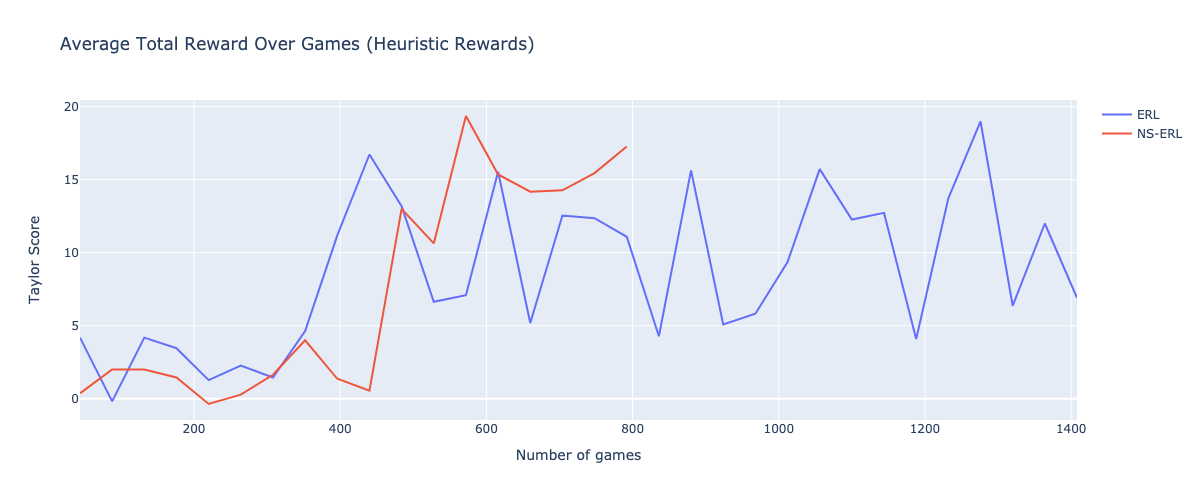

In [3]:
Image(filename="results/Total Reward Over Games Heuristic Reward.png")

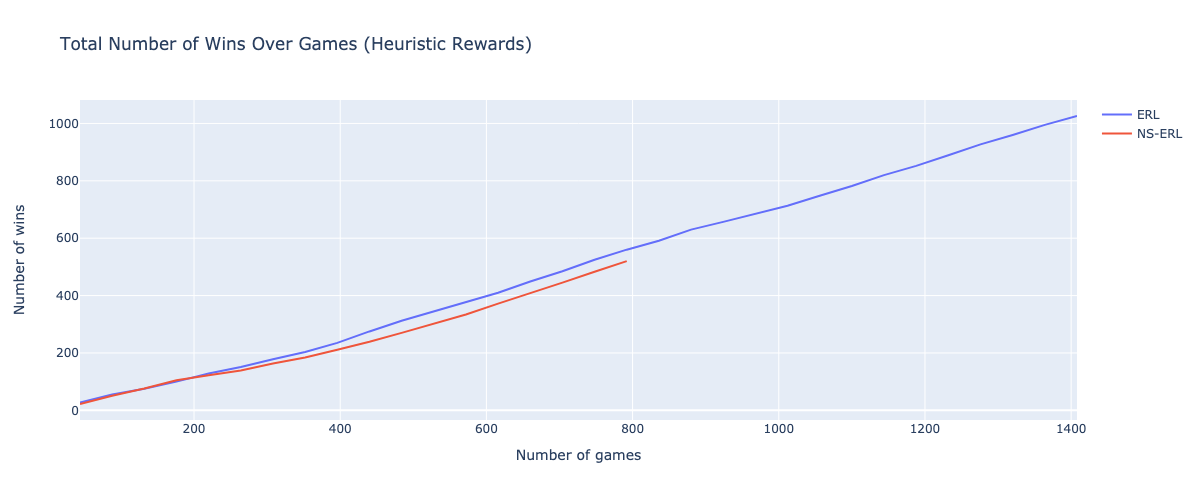

In [4]:
Image(filename="results/Number Wins Over Games Heuristic Reward.png")

As can be seen in the above results, we have no signs of learning yet. Simply put, there was not enough time to train the algorithm to a point where it can learn to effectively play the game Go. The results do however show promise that the NS-ERL algorithm is not performing significantly worse than the base ERL algorithm. Instead, it can be seen that the algorithms are performing consistently as well. In the second figure ("Total Number of Wins Over Games"), we can see that the total number of wins for both ERL and NS-ERL have a linear trend with approximately the same slope. If either algorithm had begun to learn, we would observe a non-linear trend demonstrating an increased win rate. Instead, the win rate is approximately consistent implying that the agent is winning by chance rather than skill.

### Real Rewards

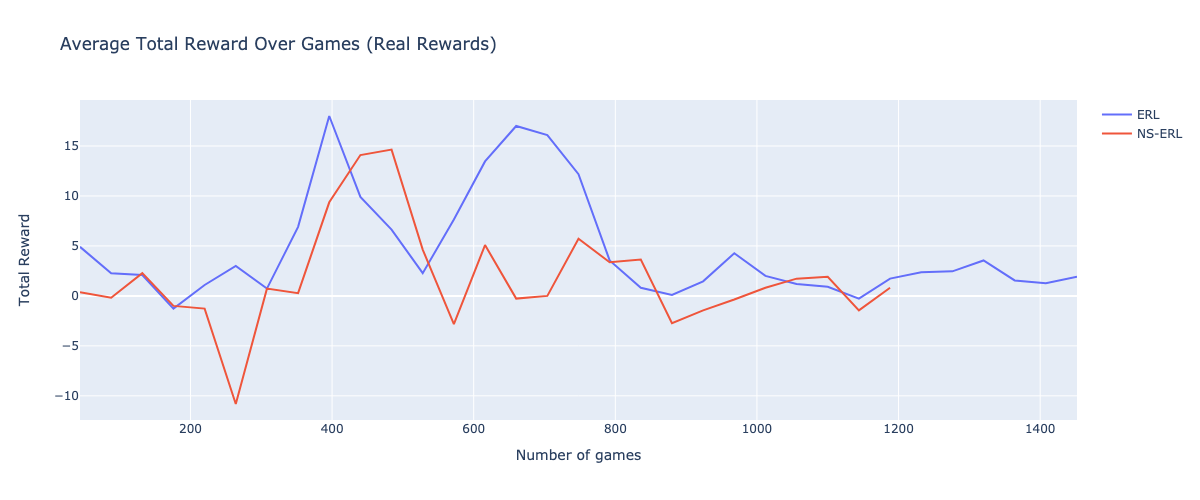

In [5]:
Image(filename="results/Total Reward Over Games Real Reward.png")

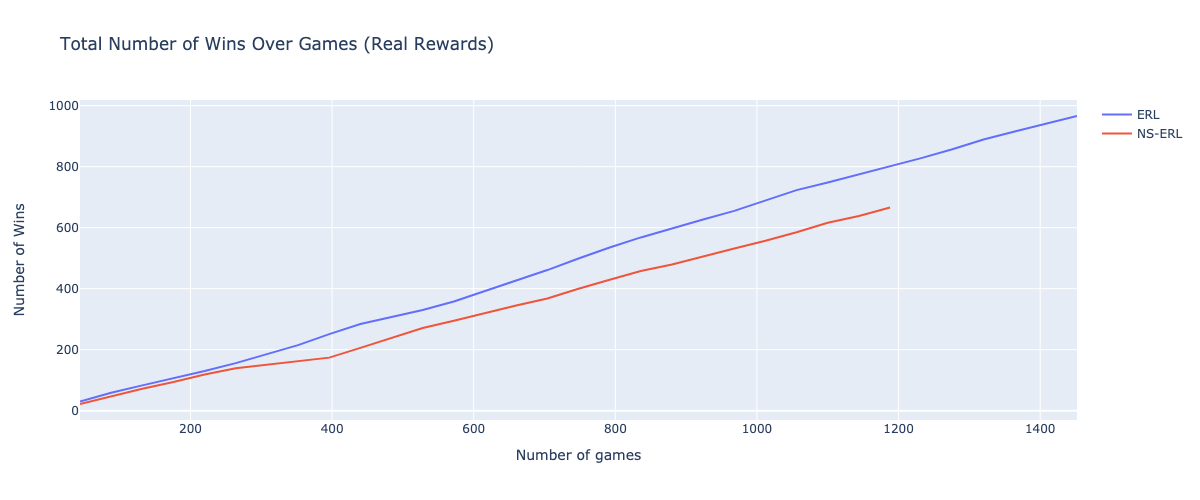

In [6]:
Image(filename="results/Number Wins Over Games Real Reward.png")

The same trends can be observed in the above two plots for the most part. We expected the real reward system to be significantly harder for both algorithms to learn due to the sparse rewards received from the environment. We do see a slight divergence in the number of wins over the number of games with the NS-ERL algorithm trailing below the ERL performance. However, this change is insignificant and even expected. The NS-ERL algorithm contains three phases as discussed above. The first phase is focused on optimizing for novelty. This builds a dataset of BC's that force a level of diversity in the population. We likely need more data in the database and more games in this first phase to effectively gain the advantages that we anticipated.

## Future work:

1. The size of the datastore needs more tuning based on more expiremental results. 
2. We need more time for training
3. Implement a method to save off the population periodically so that in the case of crashes, training can be picked up from where the last save point was. 